# Edge detection - Sobel, Lacplacian, Canny

In [2]:
# We need to include the home directory in our path, so we can read in our own module.
import os
import sys
sys.path.append(os.path.join(".."))
import cv2
import numpy as np
from utils.imutils import jimshow
from utils.imutils import jimshow_channel
from pathlib import Path
import matplotlib.pyplot as plt

## Read in the image

In [3]:
DATA_DIR = Path("../../../CDS-VIS/img")
assert DATA_DIR.exists()
image_path = str(DATA_DIR / "coins.png")
image = cv2.imread(image_path)

__Convert to greyscale__

In [4]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

__Display the image__

## Sobel operators

In [10]:
# CV_64F <- making the image into a float
sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Vertical gradients (X means along x-axis)
sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Horizontal gradients

We have mainly used 8-bit unsigned integers. Why are we using a 64-bit float now?

Transitioning from black-to-white is considered a positive slope, whereas a transition from white-to-black is a negative slope. 

If you don’t use a floating point data type when computing the gradient magnitude, you will miss edges, specifically the white-to-black transitions.

In order to ensure you catch all edges, use a floating point data type, then take the absolute value of the gradient image and convert it back to an 8-bit unsigned integer.

In [14]:
def float_to_uint8(img) -> np.ndarray:
    return np.uint8(np.absolute(img))

sobelX = float_to_uint8(sobelX)
sobelY = float_to_uint8(sobelY)

__Compare kernel outputs__

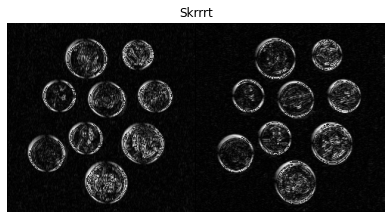

In [15]:
stacked = np.hstack((sobelX, sobelY))
jimshow_channel(stacked, "Skrrrt")

## Combined Sobel

In order to combine the gradient images in both the x and y direction, we can apply a bitwise OR. 

Remember, an OR operation is true when either pixel is greater than zero. 

Therefore, a given pixel will be ```True``` if either a horizontal or vertical edge is present.

In [16]:
sobel_combined = cv2.bitwise_or(sobelX, sobelY)

In [17]:
sobel_combined

array([[ 0, 12,  6, ..., 10, 14,  0],
       [ 2, 11,  6, ...,  7, 21,  2],
       [ 4, 11,  1, ...,  2, 20,  0],
       ...,
       [ 4,  7, 10, ..., 13,  1,  2],
       [10,  2, 13, ..., 13,  2,  4],
       [ 0,  6,  8, ...,  4,  4,  0]], dtype=uint8)

## Laplacian

Laplacian operator returns a single gradient, no need to perform two passes.

In [18]:
laplace = cv2.Laplacian(gray, cv2.CV_64F)
laplace = float_to_uint8(laplace)

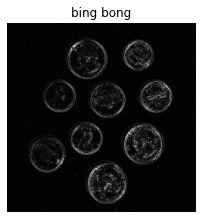

In [20]:
jimshow_channel(laplace, "bing bong")

__Perform Canny__

In [24]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

blurred = cv2.GaussianBlur(gray, (5,5), 0)
canny_img = auto_canny(blurred)
canny_manual = cv2.Canny(gray, 30, 150)

Manually setting upper and lower bounds.

For one way to set thresholds automatically, consider this website:

https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/

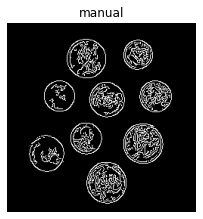

In [25]:
jimshow_channel(canny_manual, "manual")

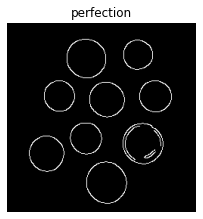

In [23]:
jimshow_channel(canny_img, "perfection")

## Find contours

There are three arguments in cv2.findContours() function.

```cv2.findContours(image, contour_retrieval_mode, contour_approximation_method)```

And it outputs the image, contours and hierarchy. ```contours``` is a Python list of all the contours in the image. 

Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html

## Draw contours

For these final ones, just have a look at Ross' markdown

```cv2.drawContours(image, contours, fill, colour, thickness)```

## Counting coins

What kind of object is the contour object ```cnts```?